**IF867 - Introdução à Aprendizagem Profunda**
# Análise Comparativa de Modelos de Aprendizagem Profunda para Reconhecimento de Expressões Faciais
Este notebook tem como objetivo descrever os passos necessários para treinar e testar diversos modelos de aprendizagem profunda para resolver a tarefa de reconhecimento de expressões faciais (do inglês Facial Expression Recognition, ou FER), além de utilizar métricas quantitativas e qualitativas para avaliar os resultados obtidos.


# Setup


Inicialmente, é necessário importar as bibliotecas que serão utilizadas durante o projeto.



*   import numpy as **np**: Numpy é utilizada para cálculos numéricos eficientes e manipulação de arrays.
*   impoty pandas as **pd**: Pandas é utilizada para manipulação e análise de dados com DataFrames.
*   import **torch**: PyTorch é uma biblioteca de aprendizado de máquina que facilita a criação de modelos de redes neurais.
*   from torch import **nn**: é um submódulo do PyTorch que fornece classes e funções para a criação de redes neurais.
*   from torch.utils.data import **Dataset**, **Dataloader**, **Random_split**, **WeightedRandomSampler**: Estes módulos são usados para gerenciar e carregar dados e auxiliar nos experimentos.
*   from torchvision.transforms import **v2**: é um submódulo utilizado para realizar transformações de dados, como redimensionamento e normalização de imagens.
*   from torchvision.datasets import **ImageFolder**: ImageFolder é uma classe que facilita o carregamento de dados de imagens organizados em diretórios.
*   from torchvision.models import **vgg19, VGG19_Weights, resnet18, ResNet18_Weights, efficientnet_b0, EfficientNet_B0_Weights, vit_b_16 ViT_B_16_Weights**: São modelos de redes neurais pré-treinados fornecidos pelo torchvision e que serão o foco da comparação.
*   from sklearn.metrics import **confusion_matrix, accuracy_score, classification_report**: Estas funções são usadas para avaliar o desempenho dos modelos de classificação.
*   import matplotlib.pyplot as **plt**: Matplotlib é uma biblioteca de plotagem que é usada para criar visualizações de dados.
*   import seaborn as **sns**: Seaborn é uma biblioteca de visualização de dados.
*   from tqdm import **tqdm**: Tqdm é uma biblioteca que facilita a exibição de barras de progresso para loops, o que é útil para monitorar o progresso do treinamento dos modelos utilizados.

O comando drive.**mount**('/content/drive') monta o Google Drive no diretório especificado, possibilitando a leitura e gravação de arquivos no Google Drive diretamente do Colab, como se fosse uma pasta local do computador.


In [ ]:
import torch

import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler

from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights, resnet18, ResNet18_Weights, efficientnet_b0, EfficientNet_B0_Weights, vit_b_16, ViT_B_16_Weights
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Agora definimos a pasta do Drive onde serão salvos tanto o conjunto de dados quanto os modelos:

In [ ]:
folder_path = '/content/drive/MyDrive/Deep_Learning_FER_Project'

As linhas de código abaixo são responsáveis por carregar o conjunto de dados escolhido (RAF-DB) da plataforma Kaggle, disponível em https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset, para a pasta desejada. Caso já tenha carregado o conjunto, elas não são necessárias.

In [ ]:
!mkdir  ~/.kaggle/
! cp '{folder_path}/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download shuvoalok/raf-db-dataset

cp: cannot stat '/content/drive/MyDrive/Deep Learning/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset
License(s): other
100% 37.7M/37.7M [00:00<00:00, 131MB/s] 
100% 37.7M/37.7M [00:00<00:00, 99.7MB/s]


In [ ]:
!unzip raf-db-dataset.zip -d '{folder_path}'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_00987_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_00990_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_00991_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_00992_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_01002_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_01010_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_01011_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_01013_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_01015_aligned.jpg  
  inflating: /content/drive/MyDrive/Deep Learning/DATASET/train/5/train_01017_aligned.jpg  
  inflating: /content

Os passos descritos a seguir são essenciais para garantir a reprodutibilidade e a correta configuração do ambiente de execução do PyTorch.

Definir as "manual_seeds" estabelece a semente para os geradores de números aleatórios do PyTorch, assegurando que os resultados de operações dependentes de aleatoriedade sejam consistentes em diferentes execuções. Isso é fundamental para experimentos científicos, pois permite que outros pesquisadores ou o próprio autor possam replicar os resultados.

Além disso, configuramos o dispositivo de execução, optando pela GPU, se disponível, para acelerar o processamento de imagens, ou pela CPU, caso contrário. Essa abordagem permite que o código se adapte ao hardware disponível, maximizando a eficiência dos cálculos.

In [ ]:
torch.manual_seed(9)
torch.cuda.manual_seed(9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')


Para o carregamento dos dados, foi utilizada a classe ImageFolder, que nada mais é que um dataloader genérico que pressupõe que as imagens estejam organizadas em pastas, sendo cada pasta correspondente a uma classe específica.
Os dados vieram divididos em conjuntos de treino e teste, e o conjunto de treinamento foi dividido de forma a criar um conjunto de validação, necessário para validar o desempenho dos modelos durante o treinamento.

In [ ]:
train_data = ImageFolder(f'{folder_path}/DATASET/train')

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, [train_size, val_size])

test_data = ImageFolder(f'{folder_path}/DATASET/test')

len_data = len(train_data) + len(val_data) + len(test_data)
(len(train_data), len(train_data)/len_data), (len(val_data), len(val_data)/len_data), (len(test_data), len(test_data)/ len_data), len_data

((9816, 0.6399374144337963),
 (2455, 0.160049546906578),
 (3068, 0.2000130386596258),
 15339)

# Análise dos dados

Os códigos abaixo são responsáveis por verificar a natureza dos dados, seja visualizando exemplos do conjunto ou verificando a distribuição das amostras entre as classes.

In [ ]:
train_data[0][0].size

(100, 100)

In [ ]:
number_to_class = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']
NUM_CLASSES = len(number_to_class)

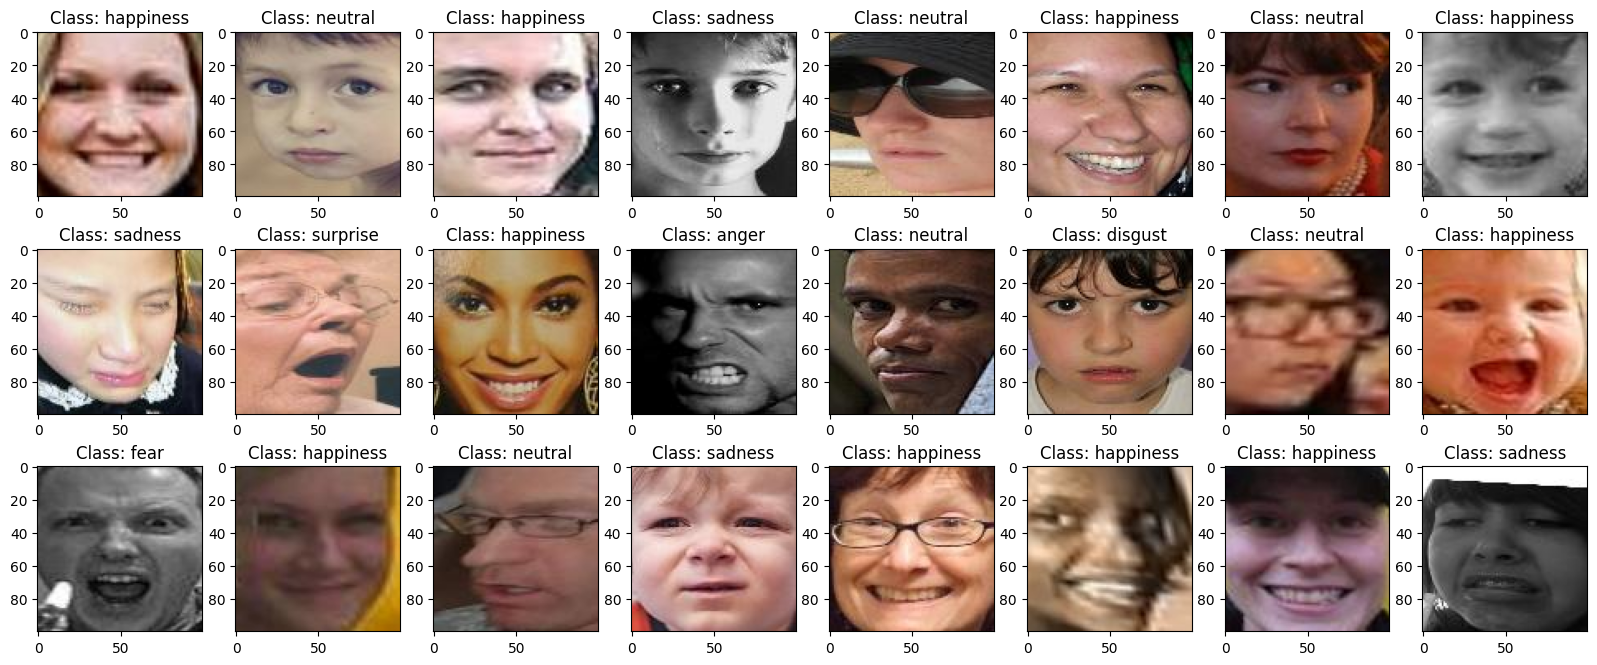

In [ ]:
fig, ax = plt.subplots(3, 8, figsize=(20, 8))
for i in range(24):
    ax[i//8, i%8].imshow(train_data[i][0])
    ax[i//8, i%8].set_title(f'Class: {number_to_class[train_data[i][1]]}')
    ax[i//8, i%8].axis('on')

plt.show()

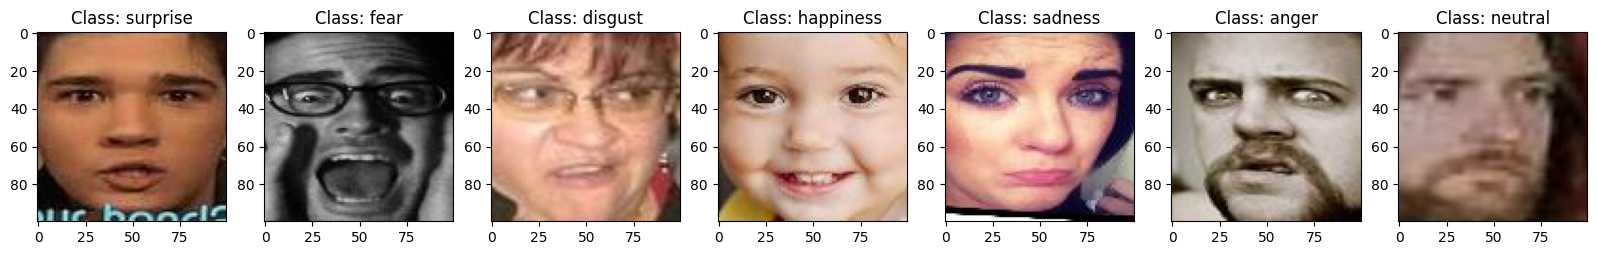

In [ ]:
class_examples_idx = [-1] * NUM_CLASSES
for idx in range(len(train_data)):
    class_idx = int(train_data[idx][1])
    if class_examples_idx[class_idx] == -1:
        class_examples_idx[class_idx] = idx
        if -1 not in class_examples_idx:
            break

fig, ax = plt.subplots(1, NUM_CLASSES, figsize=(20, 8))

for i in range(NUM_CLASSES):
  ax[i].imshow(train_data[class_examples_idx[i]][0])
  ax[i].set_title(f'Class: {number_to_class[i]}')
  ax[i].axis('on')

plt.show()

Como é possível perceber no código abaixo, o conjunto de dados utilizado é desbalanceado, o que pode afetar o desempenho dos modelos e deve ser levado em consideração.

Train class counts: {'surprise': 1016, 'fear': 226, 'disgust': 570, 'happiness': 3828, 'sadness': 1598, 'anger': 556, 'neutral': 2022}
Validation class counts: {'surprise': 274, 'fear': 55, 'disgust': 147, 'happiness': 944, 'sadness': 384, 'anger': 149, 'neutral': 502}
Test class counts: {'surprise': 329, 'fear': 74, 'disgust': 160, 'happiness': 1185, 'sadness': 478, 'anger': 162, 'neutral': 680}


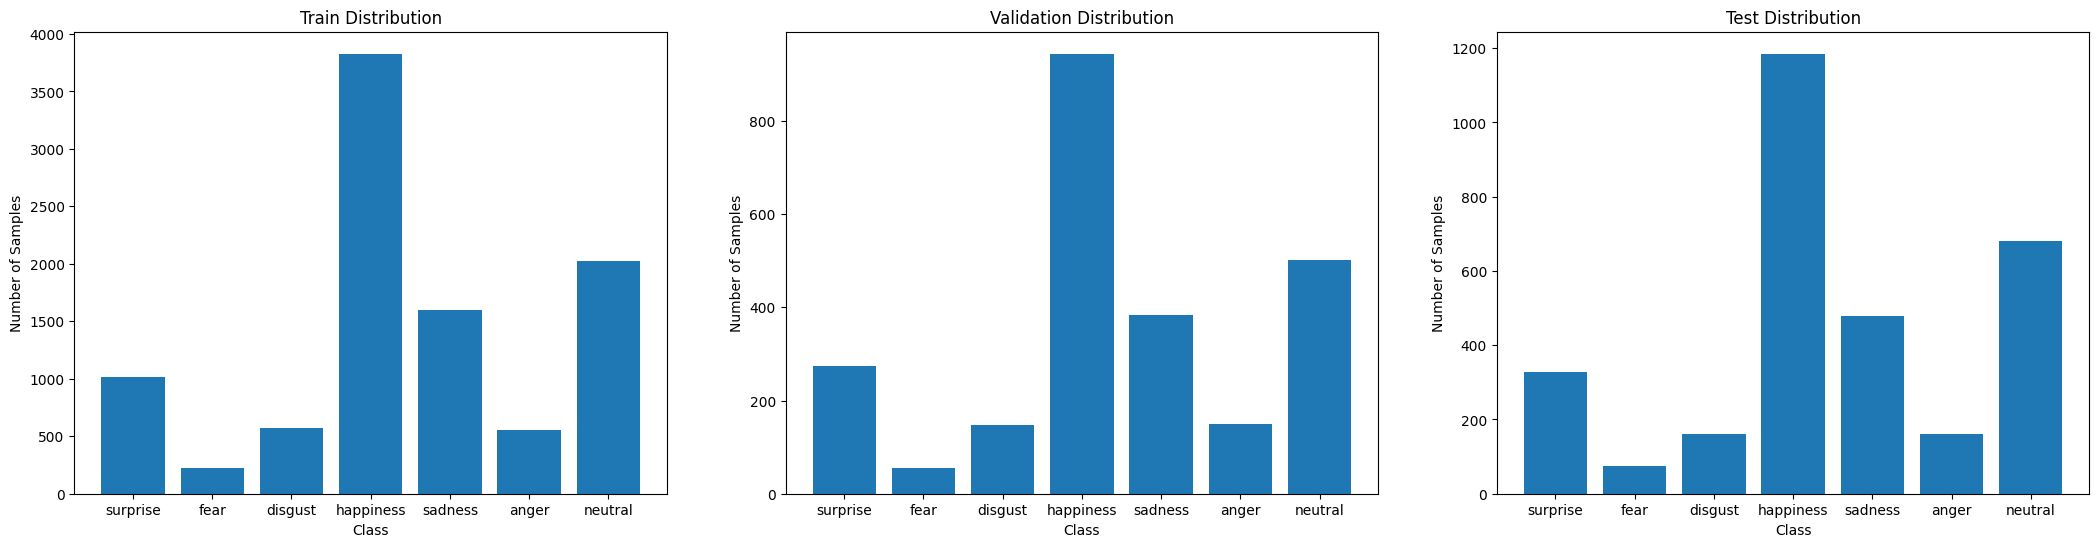

In [ ]:
def count_classes(subset):
    class_counts = {class_name: 0 for class_name in number_to_class}
    for idx in subset.indices:
        _, label = subset.dataset.imgs[idx]
        class_idx = int(subset.dataset.classes[label]) - 1
        class_name = number_to_class[class_idx]
        class_counts[class_name] += 1
    return class_counts

train_class_counts_dict = count_classes(train_data)
val_class_counts_dict = count_classes(val_data)

test_class_indices = torch.tensor(test_data.targets)
test_class_counts = torch.bincount(test_class_indices)
test_class_counts_dict = {number_to_class[class_idx]: count.item() for class_idx, count in enumerate(test_class_counts) if count > 0}

print("Train class counts:", train_class_counts_dict)
print("Validation class counts:", val_class_counts_dict)
print("Test class counts:", test_class_counts_dict)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(26, 6))

ax1.bar(train_class_counts_dict.keys(), train_class_counts_dict.values())
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Train Distribution')

ax2.bar(val_class_counts_dict.keys(), val_class_counts_dict.values())
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Validation Distribution')

ax3.bar(test_class_counts_dict.keys(), test_class_counts_dict.values())
ax3.set_xlabel('Class')
ax3.set_ylabel('Number of Samples')
ax3.set_title('Test Distribution')

plt.show()

Class counts: {'surprise': 1619, 'fear': 355, 'disgust': 877, 'happiness': 5957, 'sadness': 2460, 'anger': 867, 'neutral': 3204}


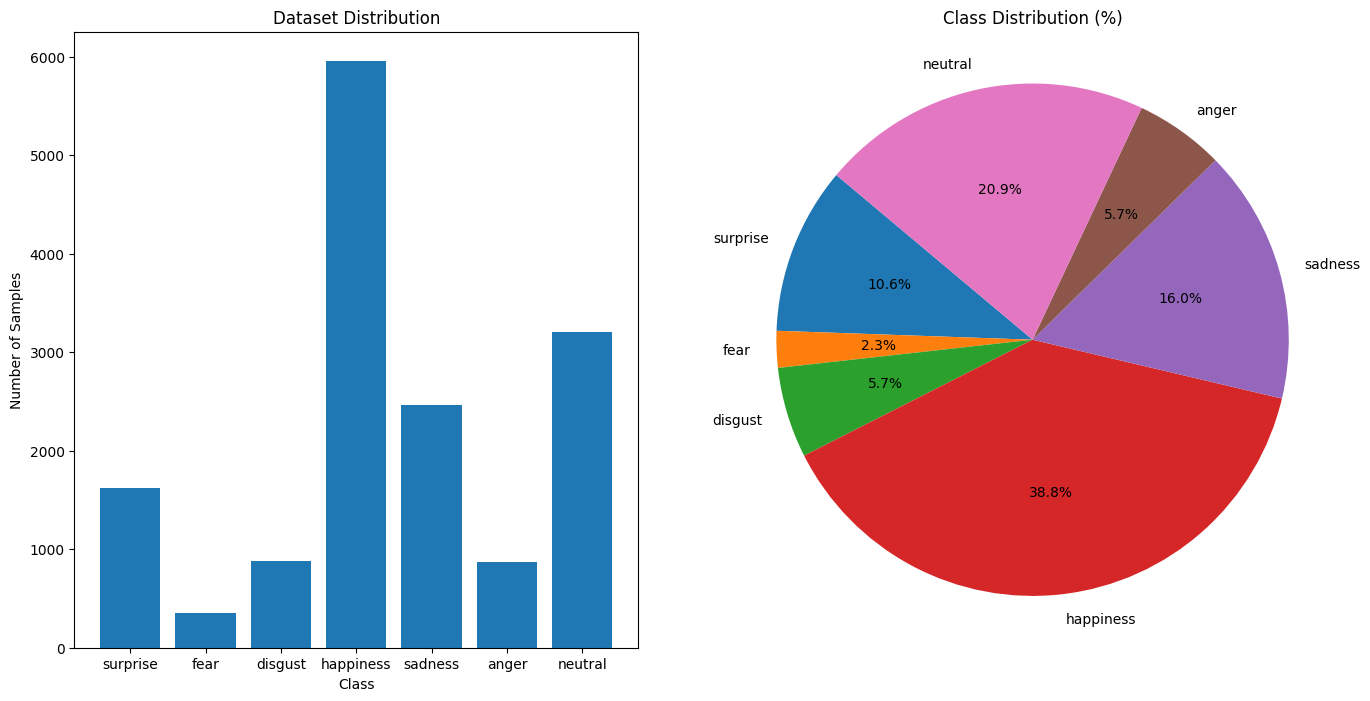

In [ ]:
dataset_class_counts_dict = {class_name: train_class_counts_dict[class_name] + val_class_counts_dict[class_name] + test_class_counts_dict[class_name] for class_name in number_to_class}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

print("Class counts:", dataset_class_counts_dict)

ax1.bar(dataset_class_counts_dict.keys(), dataset_class_counts_dict.values())
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Dataset Distribution')

ax2.pie(dataset_class_counts_dict.values(), labels=dataset_class_counts_dict.keys(), autopct='%1.1f%%', startangle=140)
ax2.axis('equal')
ax2.set_title('Class Distribution (%)')

plt.show()

# Preparação do DataLoader



Essa seção é responsável por passar os dados então carregados para Datasets customizados, de forma a permitir a utilização das transformações de forma simultânea no DataLoader (a transformação só será aplicada quando o DataLoader precisar da amostra, ao contrário de aplicar as transformações no carregamento do dataset)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
IMAGE_SIZE = 224

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomRotation(10),
    v2.RandomResizedCrop(IMAGE_SIZE, scale=(0.7, 1.3)),
    v2.RandomHorizontalFlip(),
    v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

data_transforms = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

In [ ]:
train_dataset = MyDataset(train_data, train_transforms)
val_dataset = MyDataset(val_data, data_transforms)
test_dataset = MyDataset(test_data, data_transforms)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

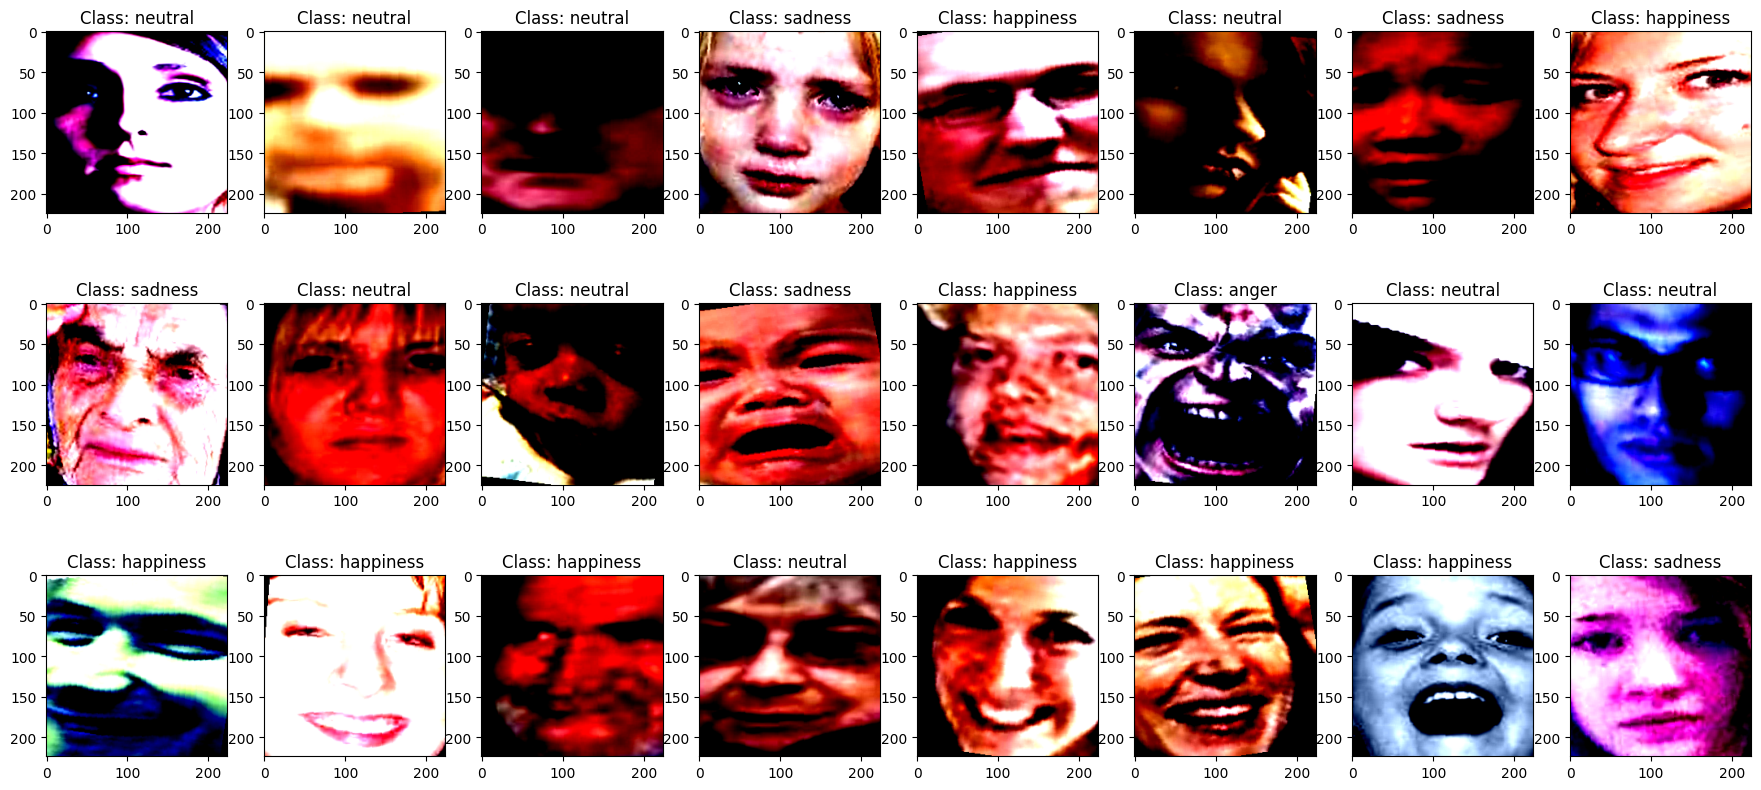

In [ ]:
it = iter(train_loader)
x, y = next(it)

fig, ax = plt.subplots(3, 8, figsize=(22, 10))
for i in range(24):
    ax[i//8, i%8].imshow(x[i].permute(1, 2, 0))
    ax[i//8, i%8].set_title(f'Class: {number_to_class[y[i].item()]}')
    ax[i//8, i%8].axis('on')

plt.show()

# Funções Importantes



Os códigos abaixo contém funções importantes que serão utilizadas no treimamento ou avaliação dos modelos.


*   train: é um template de treinamento e validação que pode ser utilizado por qualquer uma das redes neurais. Utiliza uma técnica de checkpointing.
*   plot_metrics: plota em um gráfico as métricas de treinamento dos modelos (perda de treino, acurácia de treino, perda de validação e acurácia de validação), de forma a facilitar a visualização desses dados e identificar overfitting.

*   test: é um template de teste que pode ser utilizado por qualquer uma das redes neurais.
*   evaluate_model: chama a função de teste e cria um relatório de classificação e a matriz de confusão da previsão dos modelos, a fim de extrair as métricas quantitativas relevantes.
*   init_model: como a função de treino utiliza checkpoint, é necessário definir os valores que serão carregados pelo checkpoint quando o modelo não iniciou o treino.





In [ ]:
def train(model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path):

  model.to(device)

  checkpoint = torch.load(f'{folder_path}/MODELS/{model_name}_checkpoint.pth', map_location=device)

  start_epoch = checkpoint['epoch']
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  best_val_acc = checkpoint['best_val_acc']

  metrics = torch.load(f'{folder_path}/METRICS/{model_name}_metrics.pth')

  train_losses = metrics['train_losses']
  train_acc = metrics['train_accuracies']
  val_losses = metrics['val_losses']
  val_acc = metrics['val_accuracies']

  for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_losses.append(running_loss/len(train_loader))
    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in tqdm(val_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    if (val_accuracy >= best_val_acc):
      best_val_acc = val_accuracy

      torch.save(model.state_dict(),
        f'{folder_path}/MODELS/{model_name}_best_model.pth')

    val_acc.append(val_accuracy)

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'best_val_acc': best_val_acc},
      f'{folder_path}/MODELS/{model_name}_checkpoint.pth')

    torch.save({
      'train_losses': train_losses,
      'train_accuracies': train_acc,
      'val_losses': val_losses,
      'val_accuracies': val_acc
    }, f'{folder_path}/METRICS/{model_name}_metrics.pth')

In [ ]:
def plot_metrics(train_losses, val_losses, train_acc, val_acc):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_acc, label='Training accuracy')
  plt.plot(val_acc, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def test(model, test_loader, device):
    y_pred = []
    y_true = []

    model.to(device)
    model.eval()
    with torch.inference_mode():
        for (images, labels) in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            y_test_pred_logits = model(images)

            y_test_pred = torch.argmax(y_test_pred_logits, 1)
            y_pred.extend(y_test_pred.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_pred, y_true

In [ ]:
def evaluate_model(model, test_loader, device):
    y_pred, y_true = test(model, test_loader, device)
    print("\nClassification Report: \n", classification_report(y_true, y_pred, digits=4, target_names = number_to_class))
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=number_to_class, columns=number_to_class)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

In [ ]:
def init_model(model, optimizer, model_name, folder_path):
  torch.save( {
      'epoch': 1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'best_val_acc': 0
  }, f'{folder_path}/MODELS/{model_name}_checkpoint.pth')

  torch.save({
      'train_losses': [],
      'train_accuracies': [],
      'val_losses': [],
      'val_accuracies': []
  }, f'{folder_path}/METRICS/{model_name}_metrics.pth')

# Experimento 1

A metodologia do experimento 1 envolve a implementação e treinamento de modelos de aprendizado profundo para reconhecimento de expressões faciais. O processo começa com a inicialização do modelo e o salvamento de seus parâmetros. O treinamento é conduzido ao longo de várias épocas, onde a perda é calculada e os pesos do modelo são atualizados, com a precisão sendo avaliada em cada época. O modelo é validado usando um conjunto de dados separado e, se a precisão de validação for superior à melhor precisão registrada, o estado do modelo é salvo. As métricas de treinamento e validação são salvas para análise posterior. Após o treinamento, o modelo é testado em um conjunto de dados de teste, gerando métricas de avaliação como o relatório de classificação e a matriz de confusão para detalhar o desempenho do modelo.

In [ ]:
class VGG(nn.Module):
    def __init__(self, num_classes):
        super(VGG, self).__init__()
        self.vgg = vgg19(weights=VGG19_Weights.DEFAULT)
        self.vgg.classifier[-1] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.vgg(x)

vgg_model = VGG(NUM_CLASSES)
model_name = "VGG19"
vgg_model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.0MB/s]


VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Conv2d

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.0001)

num_epochs = 10

init_model(vgg_model, optimizer, model_name, folder_path)

train(vgg_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 133MB/s]
100%|██████████| 77/77 [00:29<00:00,  2.62it/s]


Epoch [1/10], Loss: 1.2581
Validation Loss: 0.9539, Validation Accuracy: 66.64%


100%|██████████| 77/77 [00:27<00:00,  2.82it/s]


Epoch [2/10], Loss: 0.8959
Validation Loss: 0.8055, Validation Accuracy: 70.18%


100%|██████████| 77/77 [00:27<00:00,  2.84it/s]


Epoch [3/10], Loss: 0.7761
Validation Loss: 0.7267, Validation Accuracy: 75.03%


100%|██████████| 77/77 [00:27<00:00,  2.84it/s]


Epoch [4/10], Loss: 0.6814
Validation Loss: 0.7193, Validation Accuracy: 74.05%


100%|██████████| 77/77 [00:26<00:00,  2.85it/s]


Epoch [5/10], Loss: 0.6181
Validation Loss: 0.7215, Validation Accuracy: 75.64%


100%|██████████| 77/77 [00:27<00:00,  2.79it/s]


Epoch [6/10], Loss: 0.5604
Validation Loss: 0.6350, Validation Accuracy: 77.11%


100%|██████████| 77/77 [00:27<00:00,  2.77it/s]


Epoch [7/10], Loss: 0.5163
Validation Loss: 0.6953, Validation Accuracy: 76.46%


100%|██████████| 77/77 [00:29<00:00,  2.61it/s]


Epoch [8/10], Loss: 0.4872
Validation Loss: 0.6417, Validation Accuracy: 79.67%


100%|██████████| 77/77 [00:26<00:00,  2.87it/s]


Epoch [9/10], Loss: 0.4431
Validation Loss: 0.6464, Validation Accuracy: 78.98%


100%|██████████| 77/77 [00:26<00:00,  2.88it/s]


Epoch [10/10], Loss: 0.4150
Validation Loss: 0.6524, Validation Accuracy: 79.19%


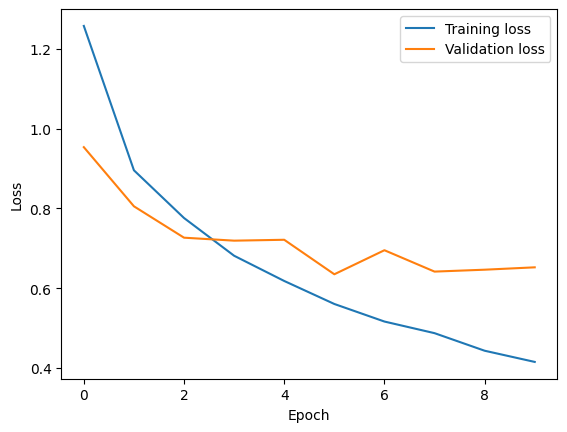

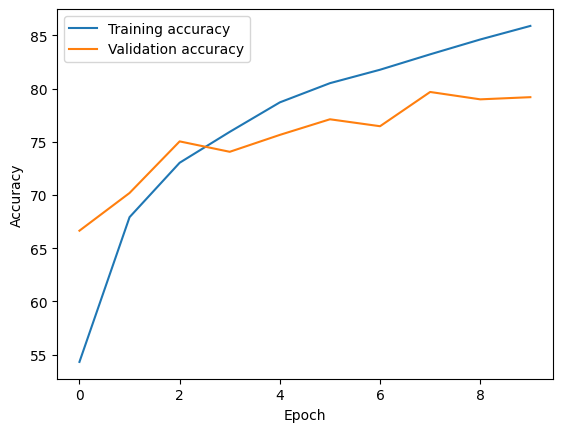

In [ ]:
vgg_metrics = torch.load(f'{folder_path}/METRICS/VGG19_metrics.pth')

train_losses = vgg_metrics['train_losses']
val_losses = vgg_metrics['val_losses']
train_acc = vgg_metrics['train_accuracies']
val_acc = vgg_metrics['val_accuracies']

plot_metrics(train_losses, val_losses, train_acc, val_acc)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

    def forward(self, x):
        return self.resnet(x)

resNet_model = ResNet18(NUM_CLASSES)
model_name = "ResNet18"
resNet_model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.2MB/s]


ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resNet_model.parameters(), lr = 0.0001)
num_epochs = 10

init_model(resNet_model, optimizer, model_name, folder_path)

train(resNet_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

100%|██████████| 77/77 [00:13<00:00,  5.59it/s]


Epoch [1/10], Loss: 0.9968
Validation Loss: 0.7829, Validation Accuracy: 73.20%


100%|██████████| 77/77 [00:13<00:00,  5.61it/s]


Epoch [2/10], Loss: 0.6465
Validation Loss: 0.6793, Validation Accuracy: 76.46%


100%|██████████| 77/77 [00:13<00:00,  5.78it/s]


Epoch [3/10], Loss: 0.5305
Validation Loss: 0.6864, Validation Accuracy: 75.40%


100%|██████████| 77/77 [00:13<00:00,  5.82it/s]


Epoch [4/10], Loss: 0.4282
Validation Loss: 0.6015, Validation Accuracy: 79.43%


100%|██████████| 77/77 [00:13<00:00,  5.79it/s]


Epoch [5/10], Loss: 0.3744
Validation Loss: 0.6346, Validation Accuracy: 78.90%


100%|██████████| 77/77 [00:13<00:00,  5.75it/s]


Epoch [6/10], Loss: 0.3115
Validation Loss: 0.6504, Validation Accuracy: 78.37%


100%|██████████| 77/77 [00:13<00:00,  5.68it/s]


Epoch [7/10], Loss: 0.2705
Validation Loss: 0.6496, Validation Accuracy: 80.12%


100%|██████████| 77/77 [00:13<00:00,  5.72it/s]


Epoch [8/10], Loss: 0.2518
Validation Loss: 0.6475, Validation Accuracy: 80.04%


100%|██████████| 77/77 [00:12<00:00,  6.14it/s]


Epoch [9/10], Loss: 0.2201
Validation Loss: 0.6537, Validation Accuracy: 79.63%


100%|██████████| 77/77 [00:13<00:00,  5.82it/s]


Epoch [10/10], Loss: 0.1874
Validation Loss: 0.6856, Validation Accuracy: 80.41%


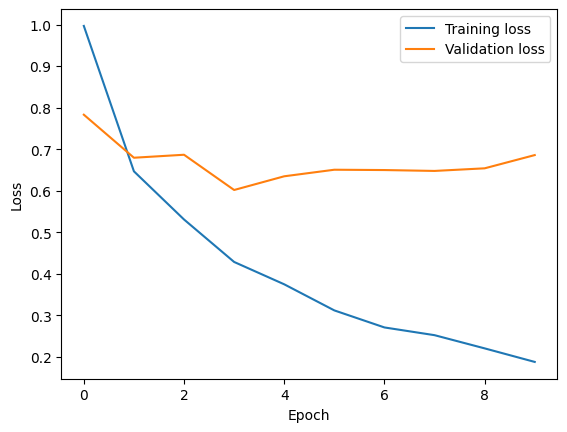

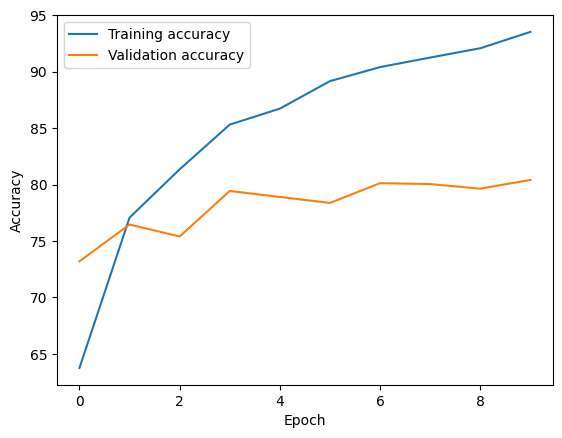

In [ ]:
resNet_metrics = torch.load(f'{folder_path}/ResNet18_metrics.pth')

train_losses = resNet_metrics['train_losses']
val_losses = resNet_metrics['val_losses']
train_acc = resNet_metrics['train_accuracies']
val_acc = resNet_metrics['val_accuracies']

plot_metrics(train_losses, val_losses, train_acc, val_acc)

In [ ]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB0, self).__init__()
        self.efficientNet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.efficientNet.classifier[1] = nn.Linear(self.efficientNet.classifier[1].in_features, num_classes, bias=True)

    def forward(self, x):
        return self.efficientNet(x)

efficientNet_model = EfficientNetB0(NUM_CLASSES)
model_name = "EfficientNet_B0"
efficientNet_model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 86.8MB/s]


EfficientNetB0(
  (efficientNet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientNet_model.parameters(), lr= 0.0001)
num_epochs = 10

init_model(efficientNet_model, optimizer, model_name, folder_path)

train(efficientNet_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

100%|██████████| 77/77 [00:12<00:00,  6.14it/s]


Epoch [1/10], Loss: 0.9694
Validation Loss: 0.8557, Validation Accuracy: 69.37%


100%|██████████| 77/77 [00:13<00:00,  5.63it/s]


Epoch [2/10], Loss: 0.7441
Validation Loss: 0.7338, Validation Accuracy: 74.42%


100%|██████████| 77/77 [00:14<00:00,  5.49it/s]


Epoch [3/10], Loss: 0.6138
Validation Loss: 0.6653, Validation Accuracy: 76.82%


100%|██████████| 77/77 [00:14<00:00,  5.49it/s]


Epoch [4/10], Loss: 0.5139
Validation Loss: 0.6443, Validation Accuracy: 77.68%


100%|██████████| 77/77 [00:12<00:00,  6.17it/s]


Epoch [5/10], Loss: 0.4335
Validation Loss: 0.6280, Validation Accuracy: 78.49%


100%|██████████| 77/77 [00:13<00:00,  5.54it/s]


Epoch [6/10], Loss: 0.3808
Validation Loss: 0.6475, Validation Accuracy: 78.82%


100%|██████████| 77/77 [00:14<00:00,  5.48it/s]


Epoch [7/10], Loss: 0.3138
Validation Loss: 0.6794, Validation Accuracy: 78.74%


100%|██████████| 77/77 [00:13<00:00,  5.67it/s]


Epoch [8/10], Loss: 0.2830
Validation Loss: 0.6808, Validation Accuracy: 78.94%


100%|██████████| 77/77 [00:12<00:00,  6.19it/s]


Epoch [9/10], Loss: 0.2425
Validation Loss: 0.7164, Validation Accuracy: 78.94%


100%|██████████| 77/77 [00:13<00:00,  5.59it/s]


Epoch [10/10], Loss: 0.2084
Validation Loss: 0.6970, Validation Accuracy: 78.90%


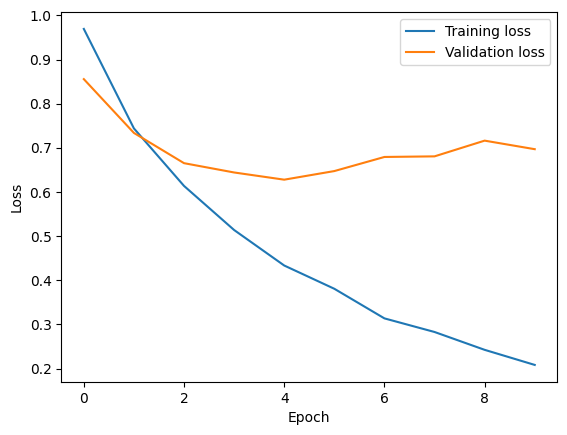

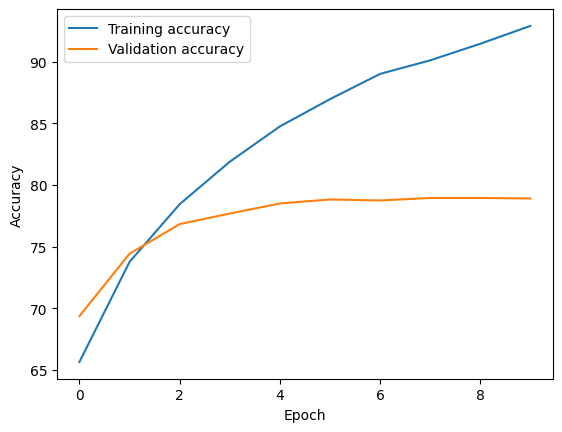

In [ ]:
efficientNet_metrics = torch.load(f'{folder_path}/EfficientNet_B0_metrics.pth')

train_losses = efficientNet_metrics['train_losses']
val_losses = efficientNet_metrics['val_losses']
train_acc = efficientNet_metrics['train_accuracies']
val_acc = efficientNet_metrics['val_accuracies']

plot_metrics(train_losses, val_losses, train_acc, val_acc)

In [ ]:
class ViT(nn.Module):
  def __init__(self, num_classes):
    super(ViT, self).__init__()
    self.vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
    self.vit.heads[0] = nn.Linear(self.vit.heads[0].in_features, num_classes, bias=True)

  def forward(self, x):
    return self.vit(x)

vit_model = ViT(num_classes=NUM_CLASSES)
model_name = "ViT"
vit_model

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 110MB/s]


ViT(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm((76

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.0001)
num_epochs = 10

init_model(vit_model, optimizer, model_name, folder_path)

train(vit_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

100%|██████████| 77/77 [10:08<00:00,  7.90s/it]


Epoch [1/10], Loss: 0.9533
Validation Loss: 0.7836, Validation Accuracy: 72.38%


100%|██████████| 77/77 [00:27<00:00,  2.84it/s]


Epoch [2/10], Loss: 0.6523
Validation Loss: 0.6899, Validation Accuracy: 75.72%


100%|██████████| 77/77 [00:27<00:00,  2.82it/s]


Epoch [3/10], Loss: 0.5387
Validation Loss: 0.6018, Validation Accuracy: 79.84%


100%|██████████| 77/77 [00:26<00:00,  2.86it/s]


Epoch [4/10], Loss: 0.4670
Validation Loss: 0.6062, Validation Accuracy: 80.00%


100%|██████████| 77/77 [00:26<00:00,  2.89it/s]


Epoch [5/10], Loss: 0.4159
Validation Loss: 0.5761, Validation Accuracy: 80.04%


100%|██████████| 77/77 [00:26<00:00,  2.88it/s]


Epoch [6/10], Loss: 0.3430
Validation Loss: 0.6473, Validation Accuracy: 79.43%


100%|██████████| 77/77 [00:27<00:00,  2.81it/s]


Epoch [7/10], Loss: 0.2978
Validation Loss: 0.6757, Validation Accuracy: 79.06%


100%|██████████| 77/77 [00:26<00:00,  2.88it/s]


Epoch [8/10], Loss: 0.2591
Validation Loss: 0.6484, Validation Accuracy: 78.37%


100%|██████████| 77/77 [00:27<00:00,  2.85it/s]


Epoch [9/10], Loss: 0.2146
Validation Loss: 0.7541, Validation Accuracy: 78.94%


100%|██████████| 77/77 [00:26<00:00,  2.88it/s]


Epoch [10/10], Loss: 0.1834
Validation Loss: 0.7254, Validation Accuracy: 80.61%


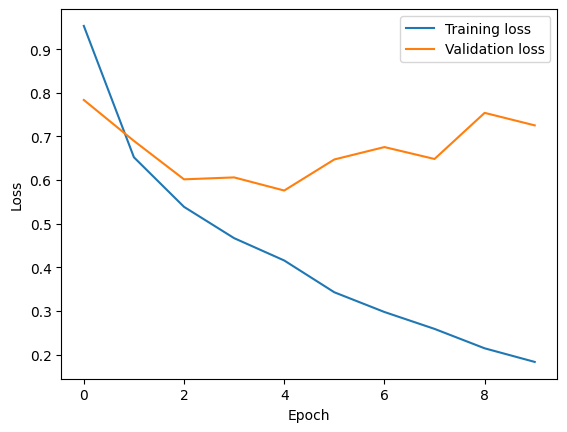

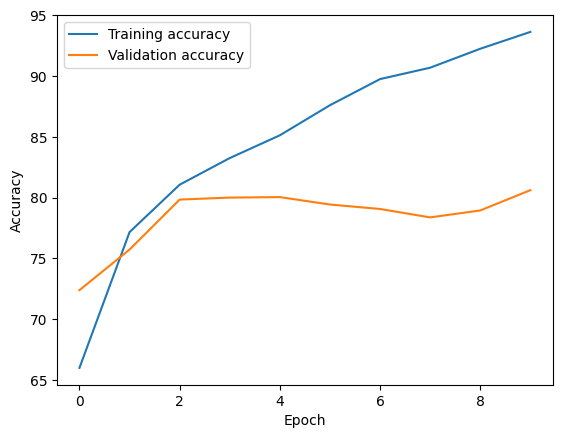

In [ ]:
vit_metrics = torch.load(f'{folder_path}/ViT_metrics.pth')

train_losses = vit_metrics['train_losses']
val_losses = vit_metrics['val_losses']
train_acc = vit_metrics['train_accuracies']
val_acc = vit_metrics['val_accuracies']

plot_metrics(train_losses, val_losses, train_acc, val_acc)

## Resultados

100%|██████████| 96/96 [00:21<00:00,  4.45it/s]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.7919    0.8328    0.8119       329
        fear     0.7708    0.5000    0.6066        74
     disgust     0.5306    0.3250    0.4031       160
   happiness     0.9187    0.9350    0.9268      1185
     sadness     0.8889    0.6862    0.7745       478
       anger     0.7329    0.7284    0.7307       162
     neutral     0.7179    0.8868    0.7934       680

    accuracy                         0.8214      3068
   macro avg     0.7645    0.6992    0.7210      3068
weighted avg     0.8223    0.8214    0.8158      3068



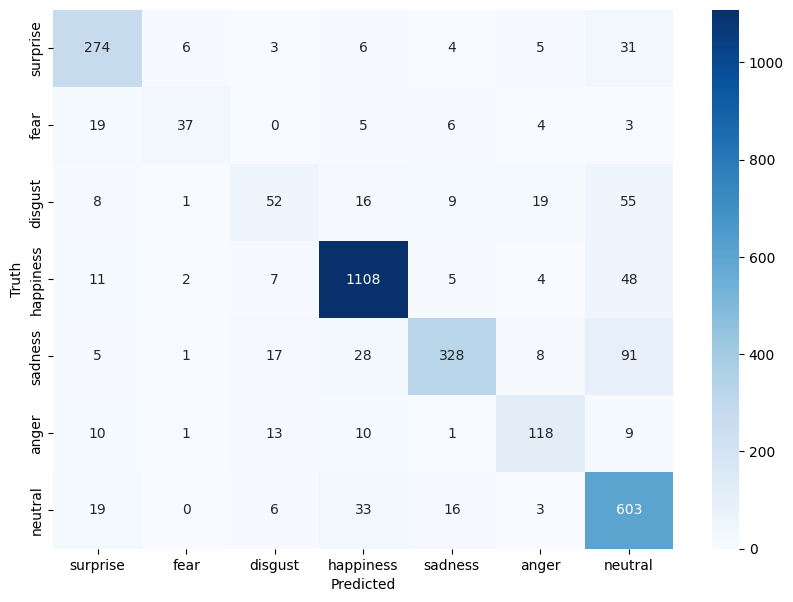

In [ ]:
vgg_checkpoint = torch.load(f'{folder_path}/MODELS/VGG19_best_model.pth')
best_vgg_model = VGG(NUM_CLASSES)
best_vgg_model.load_state_dict(vgg_checkpoint)
evaluate_model(best_vgg_model, test_loader, device)

100%|██████████| 96/96 [00:15<00:00,  6.09it/s]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.8333    0.7599    0.7949       329
        fear     0.7083    0.4595    0.5574        74
     disgust     0.5600    0.3500    0.4308       160
   happiness     0.9289    0.9038    0.9162      1185
     sadness     0.7678    0.7887    0.7781       478
       anger     0.6615    0.7840    0.7175       162
     neutral     0.7398    0.8529    0.7923       680

    accuracy                         0.8132      3068
   macro avg     0.7428    0.6998    0.7125      3068
weighted avg     0.8130    0.8132    0.8098      3068



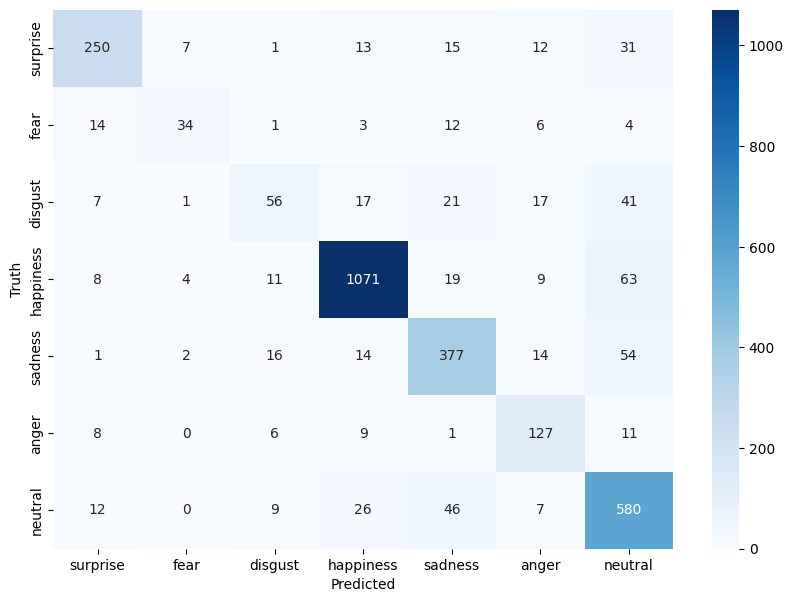

In [ ]:
resnet_checkpoint = torch.load(f'{folder_path}/MODELS/ResNet18_best_model.pth')
best_resNet_model = ResNet18(NUM_CLASSES)
best_resNet_model.load_state_dict(resnet_checkpoint)
evaluate_model(best_resNet_model, test_loader, device)

100%|██████████| 96/96 [00:17<00:00,  5.41it/s]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.7534    0.8541    0.8006       329
        fear     0.6964    0.5270    0.6000        74
     disgust     0.4888    0.5437    0.5148       160
   happiness     0.9588    0.8633    0.9085      1185
     sadness     0.7811    0.7762    0.7786       478
       anger     0.7263    0.8025    0.7625       162
     neutral     0.7459    0.8118    0.7775       680

    accuracy                         0.8093      3068
   macro avg     0.7358    0.7398    0.7346      3068
weighted avg     0.8188    0.8093    0.8120      3068



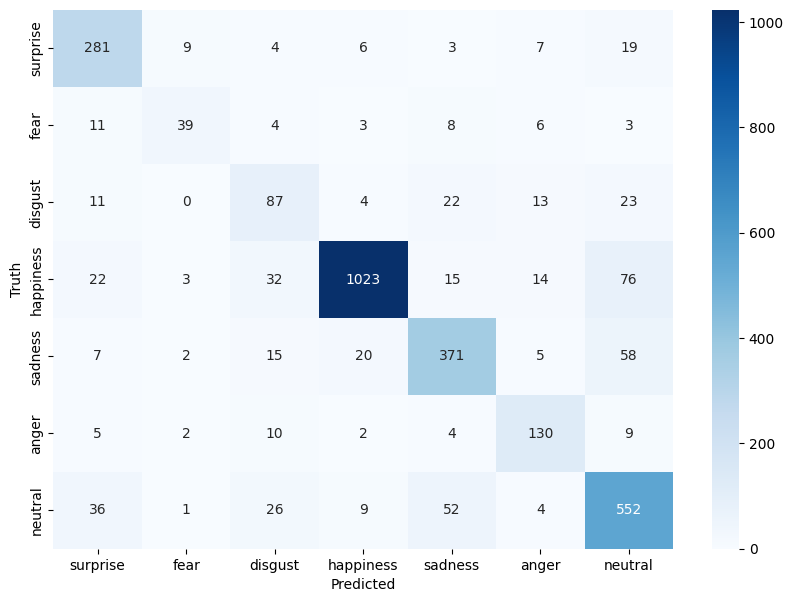

In [ ]:
efficientNet_checkpoint = torch.load(f'{folder_path}/MODELS/EfficientNet_B0_best_model.pth')
best_efficientNet_model = EfficientNetB0(NUM_CLASSES)
best_efficientNet_model.load_state_dict(efficientNet_checkpoint)
evaluate_model(best_efficientNet_model, test_loader, device)

100%|██████████| 96/96 [00:37<00:00,  2.58it/s]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.7362    0.8906    0.8061       329
        fear     0.8621    0.3378    0.4854        74
     disgust     0.4870    0.4688    0.4777       160
   happiness     0.9509    0.8819    0.9151      1185
     sadness     0.8333    0.7218    0.7735       478
       anger     0.6368    0.7901    0.7052       162
     neutral     0.7568    0.8603    0.8052       680

    accuracy                         0.8136      3068
   macro avg     0.7519    0.7073    0.7098      3068
weighted avg     0.8236    0.8136    0.8127      3068



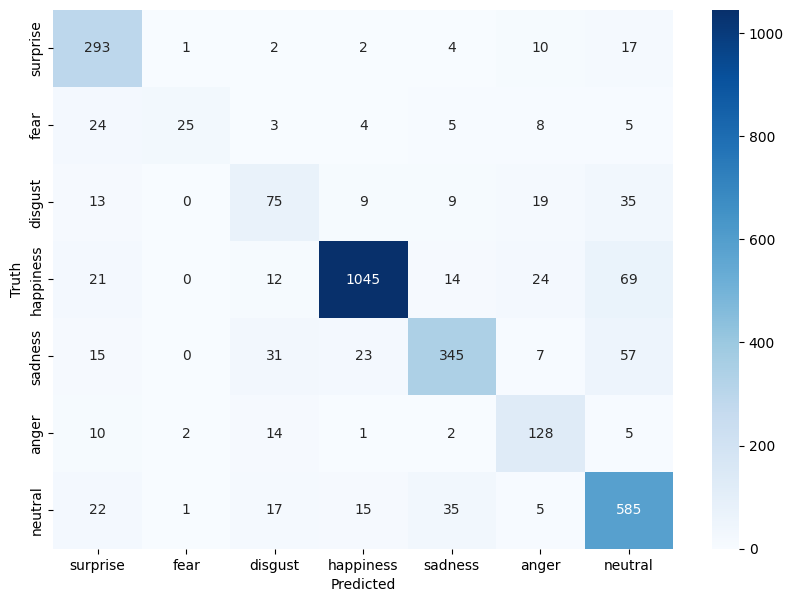

In [ ]:
viT_checkpoint = torch.load(f'{folder_path}/MODELS/ViT_best_model.pth')
best_vit_model = ViT(NUM_CLASSES)
best_vit_model.load_state_dict(viT_checkpoint)
evaluate_model(best_vit_model, test_loader, device)

# Experimento 2

O experimento 2 estende a metodologia do experimento 1, incorporando a técnica de TenCrop durante a fase de teste. TenCrop gera dez cortes da imagem original (cantos, centro e suas versões espelhadas), permitindo ao modelo fazer previsões mais robustas ao calcular a média das saídas desses cortes. Essa técnica melhora a performance dos modelos ao aumentar a diversidade das amostras de teste.

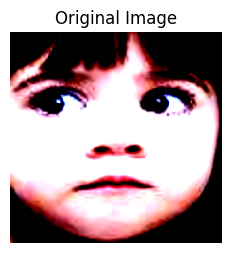

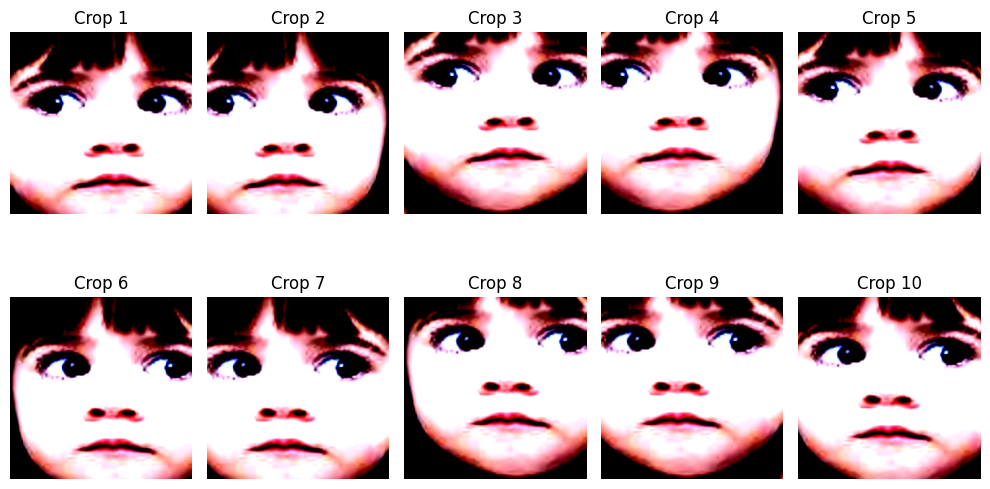

In [ ]:
tencrop = v2.Compose([
    v2.Resize(256),
    v2.TenCrop(224),
    v2.Lambda(lambda crops: torch.stack([v2.PILToTensor()(crop) for crop in crops]))
])

def test_V2(model, test_loader, device):
    y_pred = []
    y_true = []

    model.to(device)
    model.eval()
    with torch.inference_mode():
        for (images, labels) in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = []
            crops = tencrop(images)
            for crop in crops:
                output = model(crop)
                outputs.append(output)
            y_test_pred_logits = torch.mean(torch.stack(outputs), dim=0)

            y_test_pred = torch.argmax(y_test_pred_logits, 1)
            y_pred.extend(y_test_pred.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_pred, y_true


fig1 = plt.figure(figsize=(6, 6))

example_image, _ = test_dataset[0]
crops = tencrop(example_image)
example_image_display = example_image.permute(1, 2, 0).numpy()

fig1.add_subplot(1, 2, 1)
plt.imshow(example_image_display)
plt.title('Original Image')
plt.axis('off')

fig2, axes = plt.subplots(2, 5, figsize=(10, 6))


for i in range(10):
    row = i // 5
    col = i % 5
    crop_image = crops[i].permute(1, 2, 0).numpy()
    axes[row, col].imshow(crop_image)
    axes[row, col].set_title(f'Crop {i+1}')
    axes[row, col].axis('off')

axes[0, 4].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model_V2(model, test_loader, device):
    y_pred, y_true = test_V2(model, test_loader, device)
    print("\nClassification Report: \n", classification_report(y_true, y_pred, digits=4, target_names = number_to_class))
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=number_to_class, columns=number_to_class)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

## Resultados

100%|██████████| 96/96 [02:54<00:00,  1.81s/it]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.8333    0.8359    0.8346       329
        fear     0.7955    0.4730    0.5932        74
     disgust     0.5789    0.2750    0.3729       160
   happiness     0.8970    0.9477    0.9216      1185
     sadness     0.8660    0.6757    0.7591       478
       anger     0.8080    0.6235    0.7038       162
     neutral     0.7131    0.9103    0.7997       680

    accuracy                         0.8214      3068
   macro avg     0.7845    0.6773    0.7121      3068
weighted avg     0.8208    0.8214    0.8119      3068



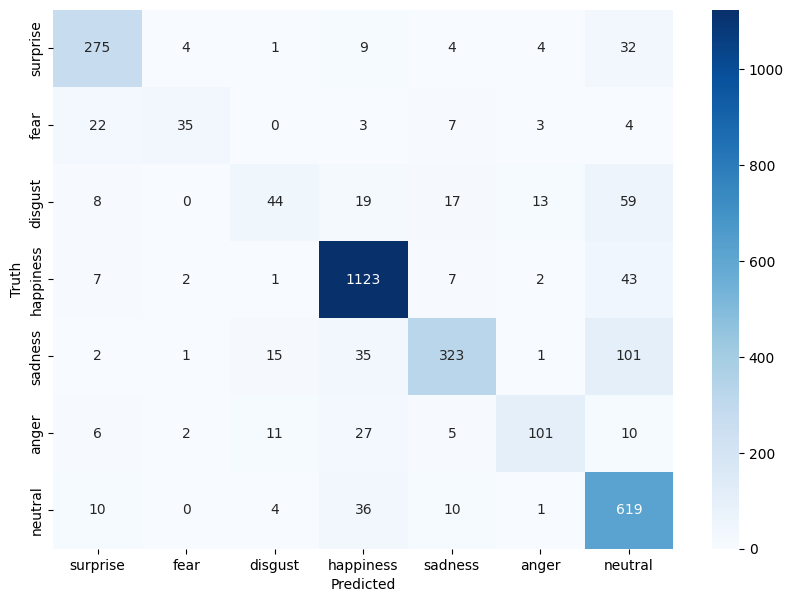

In [ ]:
vgg_checkpoint = torch.load(f'{folder_path}/MODELS/VGG19_best_model.pth')
best_vgg_model = VGG(NUM_CLASSES)
best_vgg_model.load_state_dict(vgg_checkpoint)
evaluate_model_V2(best_vgg_model, test_loader, device)

100%|██████████| 96/96 [00:30<00:00,  3.14it/s]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.8494    0.8055    0.8268       329
        fear     0.8372    0.4865    0.6154        74
     disgust     0.6522    0.4688    0.5455       160
   happiness     0.9225    0.9241    0.9233      1185
     sadness     0.8250    0.7594    0.7908       478
       anger     0.7455    0.7593    0.7523       162
     neutral     0.7469    0.8853    0.8102       680

    accuracy                         0.8341      3068
   macro avg     0.7969    0.7270    0.7520      3068
weighted avg     0.8350    0.8341    0.8311      3068



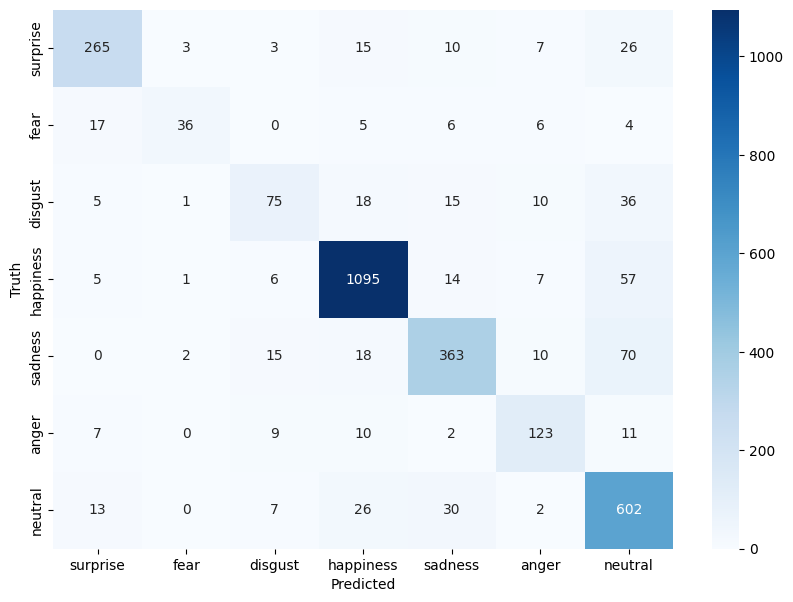

In [ ]:
resnet_checkpoint = torch.load(f'{folder_path}/MODELS/ResNet18_best_model.pth')
best_resNet_model = ResNet18(NUM_CLASSES)
best_resNet_model.load_state_dict(resnet_checkpoint)
evaluate_model_V2(best_resNet_model, test_loader, device)

100%|██████████| 96/96 [00:39<00:00,  2.43it/s]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.8088    0.8359    0.8221       329
        fear     0.6786    0.5135    0.5846        74
     disgust     0.5652    0.4875    0.5235       160
   happiness     0.9366    0.9105    0.9234      1185
     sadness     0.7893    0.7992    0.7942       478
       anger     0.7764    0.7716    0.7740       162
     neutral     0.7734    0.8382    0.8045       680

    accuracy                         0.8302      3068
   macro avg     0.7612    0.7366    0.7466      3068
weighted avg     0.8297    0.8302    0.8291      3068



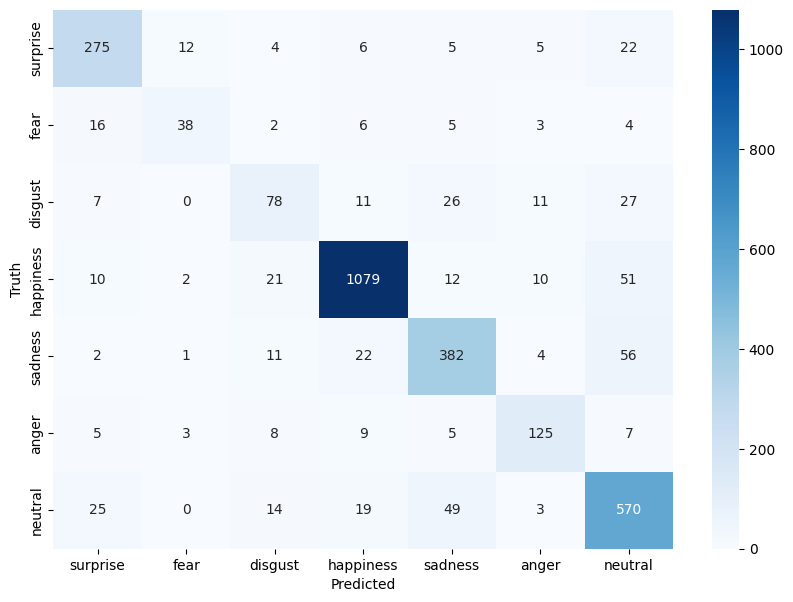

In [ ]:
efficientNet_checkpoint = torch.load(f'{folder_path}/MODELS/EfficientNet_B0_best_model.pth')
best_efficientNet_model = EfficientNetB0(NUM_CLASSES)
best_efficientNet_model.load_state_dict(efficientNet_checkpoint)
evaluate_model_V2(best_efficientNet_model, test_loader, device)

100%|██████████| 96/96 [05:42<00:00,  3.56s/it]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.7295    0.9179    0.8129       329
        fear     0.8750    0.3784    0.5283        74
     disgust     0.6094    0.4875    0.5417       160
   happiness     0.9438    0.9063    0.9247      1185
     sadness     0.8222    0.7741    0.7974       478
       anger     0.7225    0.7716    0.7463       162
     neutral     0.7954    0.8574    0.8252       680

    accuracy                         0.8344      3068
   macro avg     0.7854    0.7276    0.7395      3068
weighted avg     0.8382    0.8344    0.8319      3068



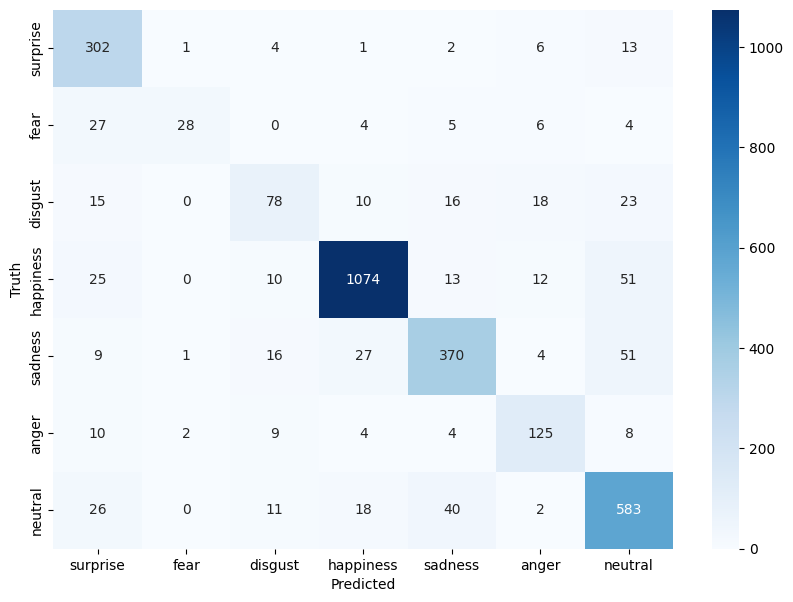

In [ ]:
viT_checkpoint = torch.load(f'{folder_path}/MODELS/ViT_best_model.pth')
best_vit_model = ViT(NUM_CLASSES)
best_vit_model.load_state_dict(viT_checkpoint)
evaluate_model_V2(best_vit_model, test_loader, device)

# Experimento 3

O experimento 3 adiciona a técnica de amostragem ponderada (WeightedRandomSampler) para lidar com o desequilíbrio de classes no conjunto de dados de treinamento. As amostras são selecionadas de forma que classes com menos exemplos tenham maior probabilidade de serem escolhidas, ajudando a reduzir o impacto do desequilíbrio de classes. Embora essa técnica possa melhorar a performance, também pode causar overfitting.

In [ ]:
class_weights = []
for class_index, count in train_class_counts_dict.items():
    class_weights.append(1/count)

sample_weights = [0] * len(train_dataset)
for (counter, idx) in enumerate(train_data.indices):
    sample_weights[counter] = class_weights[train_data.dataset.targets[idx]]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

class_weights

[0.000984251968503937,
 0.004424778761061947,
 0.0017543859649122807,
 0.00026123301985370953,
 0.0006257822277847309,
 0.0017985611510791368,
 0.0004945598417408506]

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
vgg_model = VGG(NUM_CLASSES)
model_name = "VGG19_v2"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.0001)
num_epochs = 15

init_model(vgg_model, optimizer, model_name, folder_path)

train(vgg_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

100%|██████████| 77/77 [08:20<00:00,  6.50s/it]


Epoch [1/15], Loss: 1.4381
Validation Loss: 0.9840, Validation Accuracy: 63.95%


100%|██████████| 77/77 [00:17<00:00,  4.34it/s]


Epoch [2/15], Loss: 0.9713
Validation Loss: 1.1066, Validation Accuracy: 63.50%


100%|██████████| 77/77 [00:17<00:00,  4.38it/s]


Epoch [3/15], Loss: 0.7796
Validation Loss: 0.7962, Validation Accuracy: 70.71%


100%|██████████| 77/77 [00:18<00:00,  4.25it/s]


Epoch [4/15], Loss: 0.6446
Validation Loss: 0.8426, Validation Accuracy: 70.67%


100%|██████████| 77/77 [00:17<00:00,  4.32it/s]


Epoch [5/15], Loss: 0.5415
Validation Loss: 0.8258, Validation Accuracy: 73.60%


100%|██████████| 77/77 [00:17<00:00,  4.44it/s]


Epoch [6/15], Loss: 0.4665
Validation Loss: 0.7715, Validation Accuracy: 75.32%


100%|██████████| 77/77 [00:17<00:00,  4.36it/s]


Epoch [7/15], Loss: 0.4018
Validation Loss: 0.8055, Validation Accuracy: 72.67%


100%|██████████| 77/77 [00:17<00:00,  4.34it/s]


Epoch [8/15], Loss: 0.3754
Validation Loss: 0.8058, Validation Accuracy: 74.91%


100%|██████████| 77/77 [00:17<00:00,  4.43it/s]


Epoch [9/15], Loss: 0.3191
Validation Loss: 0.7820, Validation Accuracy: 74.87%


 84%|████████▍ | 259/307 [02:33<00:27,  1.72it/s]

In [ ]:
vgg_model = VGG(NUM_CLASSES)
model_name = "VGG19_v2"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.0001)
num_epochs = 15

train(vgg_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

100%|██████████| 77/77 [07:13<00:00,  5.63s/it]


Epoch [11/15], Loss: 0.3295
Validation Loss: 0.7132, Validation Accuracy: 78.98%


100%|██████████| 77/77 [00:17<00:00,  4.43it/s]


Epoch [12/15], Loss: 0.2938
Validation Loss: 0.6998, Validation Accuracy: 77.80%


100%|██████████| 77/77 [00:17<00:00,  4.42it/s]


Epoch [13/15], Loss: 0.2797
Validation Loss: 0.7478, Validation Accuracy: 76.86%


100%|██████████| 77/77 [00:19<00:00,  4.01it/s]


Epoch [14/15], Loss: 0.2563
Validation Loss: 0.7306, Validation Accuracy: 80.04%


100%|██████████| 77/77 [00:17<00:00,  4.44it/s]


Epoch [15/15], Loss: 0.2280
Validation Loss: 0.7068, Validation Accuracy: 80.69%


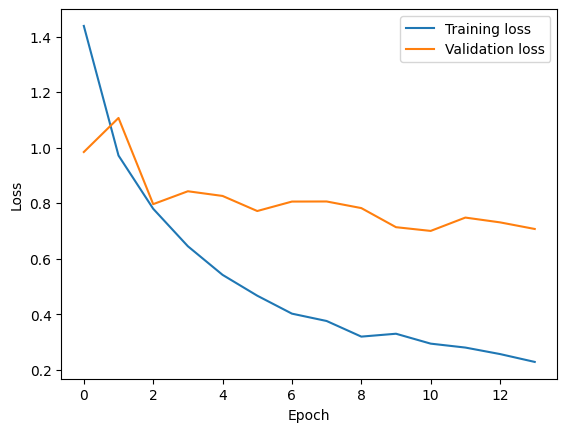

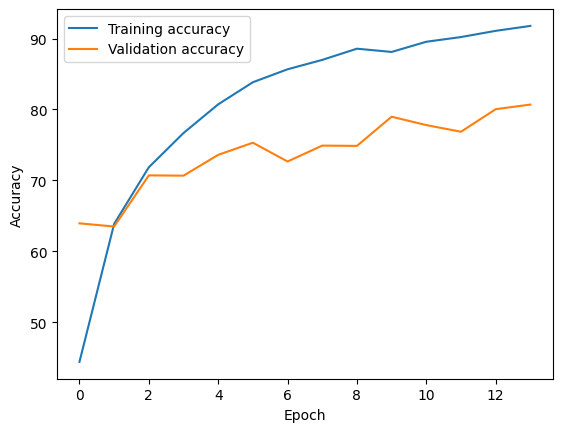

In [ ]:
vgg_metrics = torch.load(f'{folder_path}/METRICS/VGG19_v2_metrics.pth')

train_losses = vgg_metrics['train_losses']
val_losses = vgg_metrics['val_losses']
train_acc = vgg_metrics['train_accuracies']
val_acc = vgg_metrics['val_accuracies']

plot_metrics(train_losses, val_losses, train_acc, val_acc)

In [ ]:
resNet_model = ResNet18(NUM_CLASSES)
model_name = "ResNet18_v2"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resNet_model.parameters(), lr = 0.0001)
num_epochs = 15

init_model(resNet_model, optimizer, model_name, folder_path)

train(resNet_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

100%|██████████| 77/77 [06:40<00:00,  5.20s/it]


Epoch [1/15], Loss: 1.0768
Validation Loss: 0.9312, Validation Accuracy: 67.37%


100%|██████████| 77/77 [00:14<00:00,  5.27it/s]


Epoch [2/15], Loss: 0.6049
Validation Loss: 0.7617, Validation Accuracy: 73.69%


100%|██████████| 77/77 [00:14<00:00,  5.31it/s]


Epoch [3/15], Loss: 0.4440
Validation Loss: 0.8075, Validation Accuracy: 72.30%


100%|██████████| 77/77 [00:14<00:00,  5.37it/s]


Epoch [4/15], Loss: 0.3559
Validation Loss: 0.7382, Validation Accuracy: 74.26%


100%|██████████| 77/77 [00:14<00:00,  5.21it/s]


Epoch [5/15], Loss: 0.2987
Validation Loss: 0.7752, Validation Accuracy: 75.44%


100%|██████████| 77/77 [00:14<00:00,  5.21it/s]


Epoch [6/15], Loss: 0.2595
Validation Loss: 0.7430, Validation Accuracy: 75.93%


100%|██████████| 77/77 [00:14<00:00,  5.31it/s]


Epoch [7/15], Loss: 0.2218
Validation Loss: 0.7775, Validation Accuracy: 77.23%


100%|██████████| 77/77 [00:14<00:00,  5.27it/s]


Epoch [8/15], Loss: 0.1830
Validation Loss: 0.7497, Validation Accuracy: 76.90%


100%|██████████| 77/77 [00:14<00:00,  5.35it/s]


Epoch [9/15], Loss: 0.1748
Validation Loss: 0.8071, Validation Accuracy: 74.75%


100%|██████████| 77/77 [00:13<00:00,  5.54it/s]


Epoch [10/15], Loss: 0.1613
Validation Loss: 0.7894, Validation Accuracy: 76.17%


100%|██████████| 77/77 [00:14<00:00,  5.37it/s]


Epoch [11/15], Loss: 0.1603
Validation Loss: 0.7772, Validation Accuracy: 77.39%


100%|██████████| 77/77 [00:14<00:00,  5.27it/s]


Epoch [12/15], Loss: 0.1457
Validation Loss: 0.7260, Validation Accuracy: 78.98%


100%|██████████| 77/77 [00:14<00:00,  5.31it/s]


Epoch [13/15], Loss: 0.1259
Validation Loss: 0.7253, Validation Accuracy: 79.59%


100%|██████████| 77/77 [00:13<00:00,  5.52it/s]


Epoch [14/15], Loss: 0.1126
Validation Loss: 0.7698, Validation Accuracy: 78.66%


100%|██████████| 77/77 [00:13<00:00,  5.53it/s]


Epoch [15/15], Loss: 0.1221
Validation Loss: 0.7497, Validation Accuracy: 78.94%


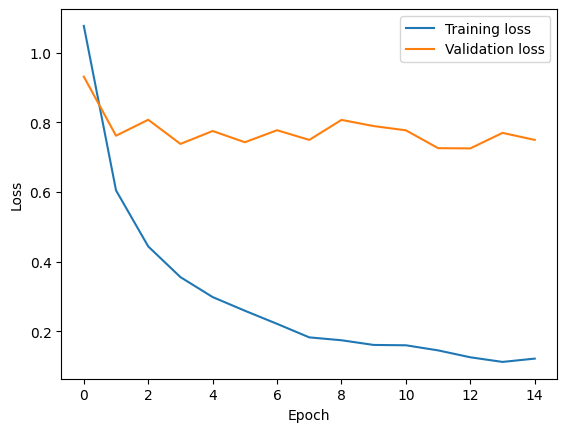

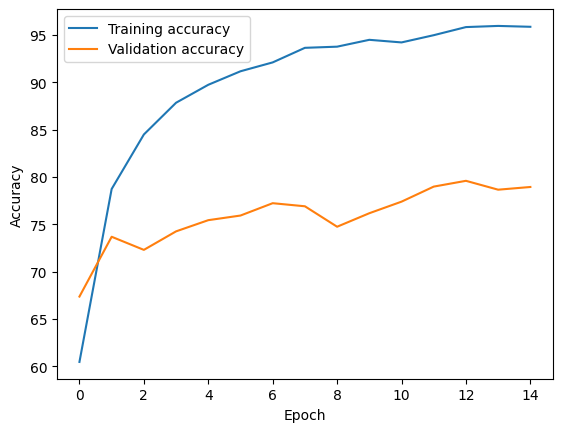

In [ ]:
resNet_metrics = torch.load(f'{folder_path}/METRICS/ResNet18_v2_metrics.pth')

train_losses = resNet_metrics['train_losses']
val_losses = resNet_metrics['val_losses']
train_acc = resNet_metrics['train_accuracies']
val_acc = resNet_metrics['val_accuracies']

plot_metrics(train_losses, val_losses, train_acc, val_acc)

In [ ]:
efficientNet_model = EfficientNetB0(NUM_CLASSES)
model_name = "EfficientNet_B0_v2"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientNet_model.parameters(), lr= 0.0001)
num_epochs = 15

init_model(efficientNet_model, optimizer, model_name, folder_path)

train(efficientNet_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

100%|██████████| 77/77 [06:42<00:00,  5.23s/it]


Epoch [1/15], Loss: 1.4774
Validation Loss: 1.2564, Validation Accuracy: 53.93%


100%|██████████| 77/77 [00:14<00:00,  5.39it/s]


Epoch [2/15], Loss: 0.8956
Validation Loss: 0.9446, Validation Accuracy: 66.80%


100%|██████████| 77/77 [00:13<00:00,  5.55it/s]


Epoch [3/15], Loss: 0.6355
Validation Loss: 0.8309, Validation Accuracy: 72.51%


100%|██████████| 77/77 [00:14<00:00,  5.30it/s]


Epoch [4/15], Loss: 0.4863
Validation Loss: 0.7541, Validation Accuracy: 74.99%


100%|██████████| 77/77 [00:14<00:00,  5.42it/s]


Epoch [5/15], Loss: 0.3958
Validation Loss: 0.7807, Validation Accuracy: 74.38%


100%|██████████| 77/77 [00:14<00:00,  5.29it/s]


Epoch [6/15], Loss: 0.3232
Validation Loss: 0.7483, Validation Accuracy: 76.50%


100%|██████████| 77/77 [00:14<00:00,  5.23it/s]


Epoch [7/15], Loss: 0.2793
Validation Loss: 0.7560, Validation Accuracy: 77.31%


100%|██████████| 77/77 [00:13<00:00,  5.64it/s]


Epoch [8/15], Loss: 0.2383
Validation Loss: 0.8035, Validation Accuracy: 76.29%


100%|██████████| 77/77 [00:14<00:00,  5.29it/s]


Epoch [9/15], Loss: 0.2128
Validation Loss: 0.7559, Validation Accuracy: 78.41%


100%|██████████| 77/77 [00:14<00:00,  5.29it/s]


Epoch [10/15], Loss: 0.1866
Validation Loss: 0.7891, Validation Accuracy: 77.96%


100%|██████████| 77/77 [00:14<00:00,  5.28it/s]


Epoch [11/15], Loss: 0.1719
Validation Loss: 0.7880, Validation Accuracy: 78.25%


100%|██████████| 77/77 [00:14<00:00,  5.47it/s]


Epoch [12/15], Loss: 0.1611
Validation Loss: 0.8027, Validation Accuracy: 77.96%


100%|██████████| 77/77 [00:14<00:00,  5.46it/s]


Epoch [13/15], Loss: 0.1343
Validation Loss: 0.8332, Validation Accuracy: 78.41%


100%|██████████| 77/77 [00:14<00:00,  5.14it/s]


Epoch [14/15], Loss: 0.1326
Validation Loss: 0.8481, Validation Accuracy: 78.66%


100%|██████████| 77/77 [00:13<00:00,  5.56it/s]


Epoch [15/15], Loss: 0.1256
Validation Loss: 0.8146, Validation Accuracy: 79.47%


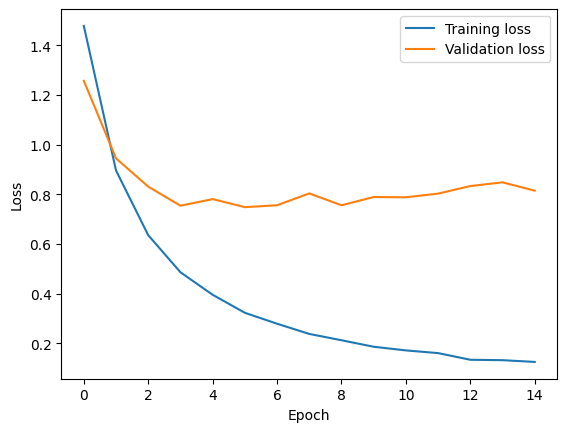

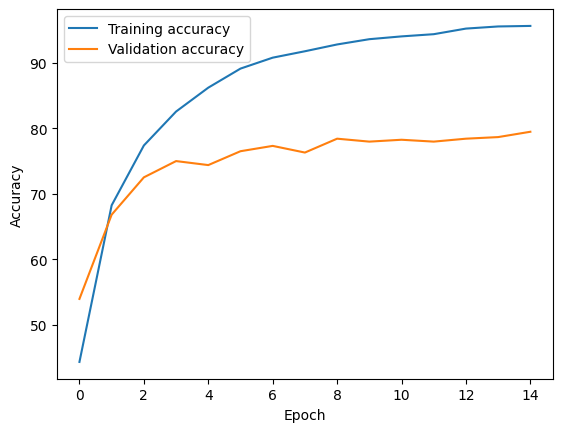

In [ ]:
efficientNet_metrics = torch.load(f'{folder_path}/METRICS/EfficientNet_B0_v2_metrics.pth')

train_losses = efficientNet_metrics['train_losses']
val_losses = efficientNet_metrics['val_losses']
train_acc = efficientNet_metrics['train_accuracies']
val_acc = efficientNet_metrics['val_accuracies']

plot_metrics(train_losses, val_losses, train_acc, val_acc)


In [ ]:
viT_model = ViT(NUM_CLASSES)
model_name = "ViT_v2"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.0001)

num_epochs = 15

init_model(vit_model, optimizer, model_name, folder_path)

train(vit_model, model_name, train_loader, val_loader, optimizer, criterion, device, num_epochs, folder_path)

100%|██████████| 77/77 [15:00<00:00, 11.69s/it]


Epoch [1/15], Loss: 1.0771
Validation Loss: 1.0549, Validation Accuracy: 62.20%


100%|██████████| 77/77 [00:29<00:00,  2.65it/s]


Epoch [2/15], Loss: 0.5907
Validation Loss: 0.8360, Validation Accuracy: 68.07%


100%|██████████| 77/77 [00:29<00:00,  2.61it/s]


Epoch [3/15], Loss: 0.4209
Validation Loss: 0.7320, Validation Accuracy: 75.40%


100%|██████████| 77/77 [00:29<00:00,  2.58it/s]


Epoch [4/15], Loss: 0.3326
Validation Loss: 0.7904, Validation Accuracy: 74.09%


100%|██████████| 77/77 [00:29<00:00,  2.61it/s]


Epoch [5/15], Loss: 0.2845
Validation Loss: 0.7514, Validation Accuracy: 76.86%


100%|██████████| 77/77 [00:29<00:00,  2.59it/s]


Epoch [6/15], Loss: 0.2382
Validation Loss: 0.8883, Validation Accuracy: 75.07%


100%|██████████| 77/77 [00:29<00:00,  2.59it/s]


Epoch [7/15], Loss: 0.2024
Validation Loss: 0.7643, Validation Accuracy: 76.62%


100%|██████████| 77/77 [00:29<00:00,  2.58it/s]


Epoch [8/15], Loss: 0.2062
Validation Loss: 0.8797, Validation Accuracy: 74.18%


100%|██████████| 77/77 [00:29<00:00,  2.59it/s]


Epoch [9/15], Loss: 0.1716
Validation Loss: 0.7329, Validation Accuracy: 79.59%


100%|██████████| 77/77 [00:29<00:00,  2.59it/s]


Epoch [10/15], Loss: 0.1379
Validation Loss: 0.8046, Validation Accuracy: 78.74%


100%|██████████| 77/77 [00:29<00:00,  2.61it/s]


Epoch [11/15], Loss: 0.1451
Validation Loss: 0.8938, Validation Accuracy: 75.97%


100%|██████████| 77/77 [00:29<00:00,  2.61it/s]


Epoch [12/15], Loss: 0.1354
Validation Loss: 0.7914, Validation Accuracy: 81.18%


100%|██████████| 77/77 [00:29<00:00,  2.60it/s]


Epoch [13/15], Loss: 0.1231
Validation Loss: 0.8956, Validation Accuracy: 77.76%


100%|██████████| 77/77 [00:29<00:00,  2.60it/s]


Epoch [14/15], Loss: 0.1380
Validation Loss: 1.0456, Validation Accuracy: 72.67%


100%|██████████| 77/77 [00:29<00:00,  2.57it/s]


Epoch [15/15], Loss: 0.1135
Validation Loss: 0.8624, Validation Accuracy: 78.37%


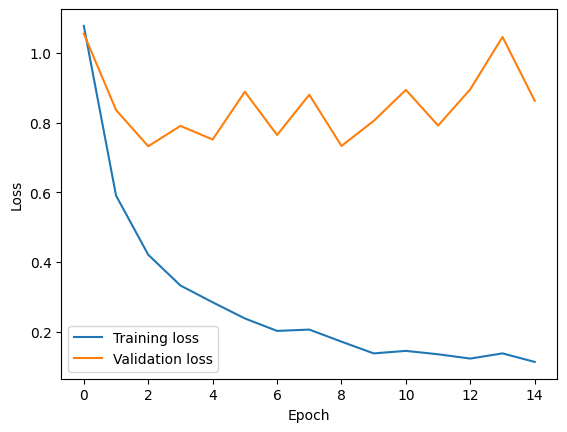

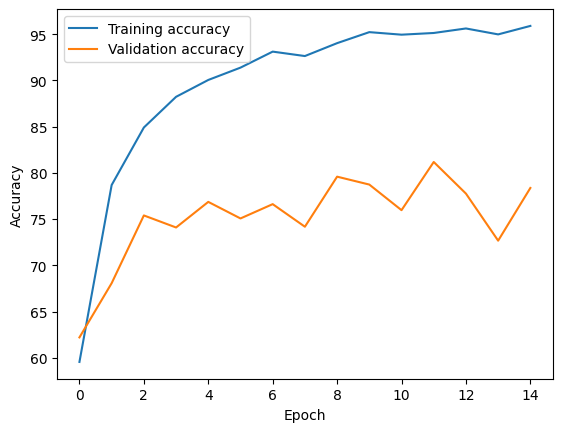

In [ ]:
viT_metrics = torch.load(f'{folder_path}/METRICS/ViT_v2_metrics.pth')

train_losses = viT_metrics['train_losses']
val_losses = viT_metrics['val_losses']
train_acc = viT_metrics['train_accuracies']
val_acc = viT_metrics['val_accuracies']

plot_metrics(train_losses, val_losses, train_acc, val_acc)

## Resultados

100%|██████████| 96/96 [09:54<00:00,  6.19s/it]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.8639    0.7720    0.8154       329
        fear     0.8857    0.4189    0.5688        74
     disgust     0.5893    0.6188    0.6037       160
   happiness     0.8776    0.9443    0.9098      1185
     sadness     0.8234    0.7510    0.7856       478
       anger     0.7436    0.7160    0.7296       162
     neutral     0.7855    0.8132    0.7991       680

    accuracy                         0.8250      3068
   macro avg     0.7956    0.7192    0.7446      3068
weighted avg     0.8254    0.8250    0.8221      3068



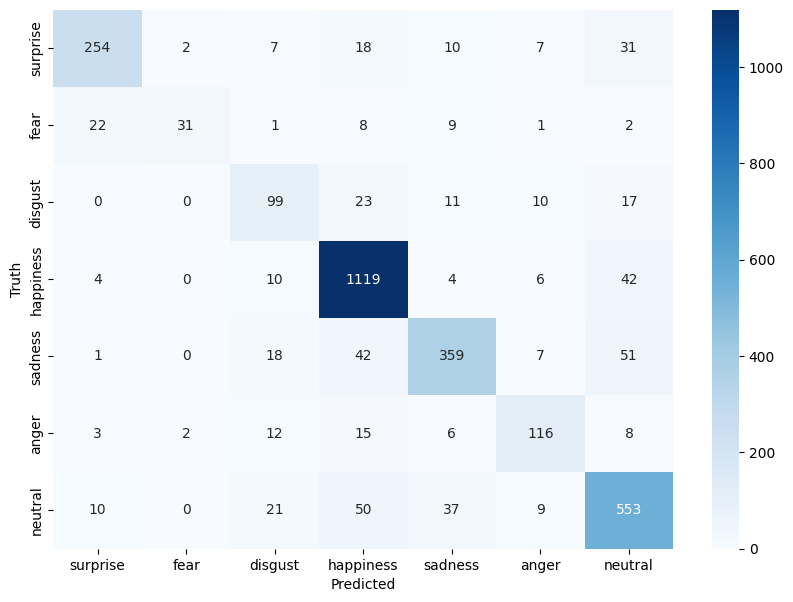

In [ ]:
vgg_checkpoint = torch.load(f'{folder_path}/MODELS/VGG19_v2_best_model.pth')
best_vgg_model = VGG(NUM_CLASSES)
best_vgg_model.load_state_dict(vgg_checkpoint)
evaluate_model_V2(best_vgg_model, test_loader, device)

100%|██████████| 96/96 [08:05<00:00,  5.06s/it]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.8368    0.8571    0.8468       329
        fear     0.7800    0.5270    0.6290        74
     disgust     0.4914    0.5375    0.5134       160
   happiness     0.9411    0.9165    0.9286      1185
     sadness     0.8322    0.7992    0.8154       478
       anger     0.6901    0.7284    0.7087       162
     neutral     0.7798    0.8279    0.8031       680

    accuracy                         0.8331      3068
   macro avg     0.7645    0.7419    0.7493      3068
weighted avg     0.8366    0.8331    0.8339      3068



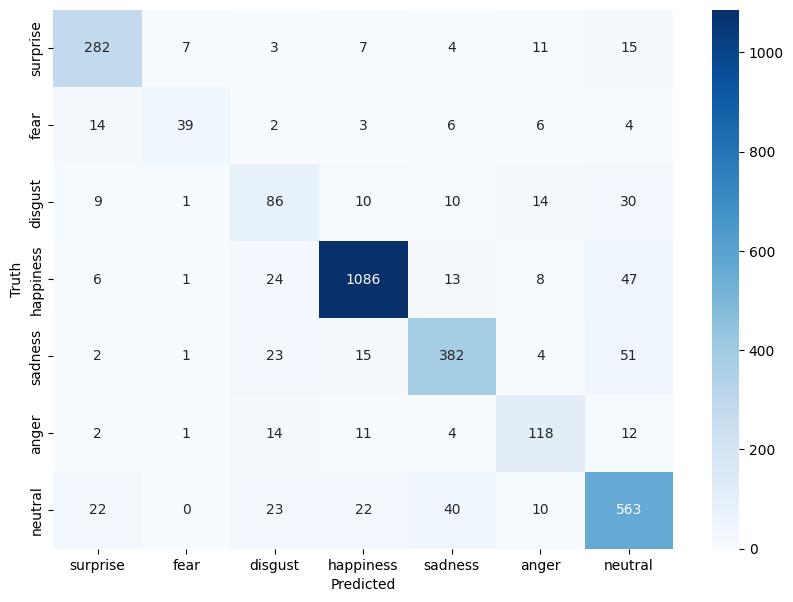

In [ ]:
resNet_checkpoint = torch.load(f'{folder_path}/MODELS/ResNet18_v2_best_model.pth')
best_resNet_model = ResNet18(NUM_CLASSES)
best_resNet_model.load_state_dict(resNet_checkpoint)
evaluate_model_V2(best_resNet_model, test_loader, device)

100%|██████████| 96/96 [09:51<00:00,  6.16s/it]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.8457    0.8328    0.8392       329
        fear     0.6479    0.6216    0.6345        74
     disgust     0.5232    0.4938    0.5080       160
   happiness     0.9174    0.9274    0.9224      1185
     sadness     0.8435    0.7552    0.7969       478
       anger     0.7079    0.7778    0.7412       162
     neutral     0.7841    0.8279    0.8054       680

    accuracy                         0.8305      3068
   macro avg     0.7528    0.7481    0.7497      3068
weighted avg     0.8305    0.8305    0.8299      3068



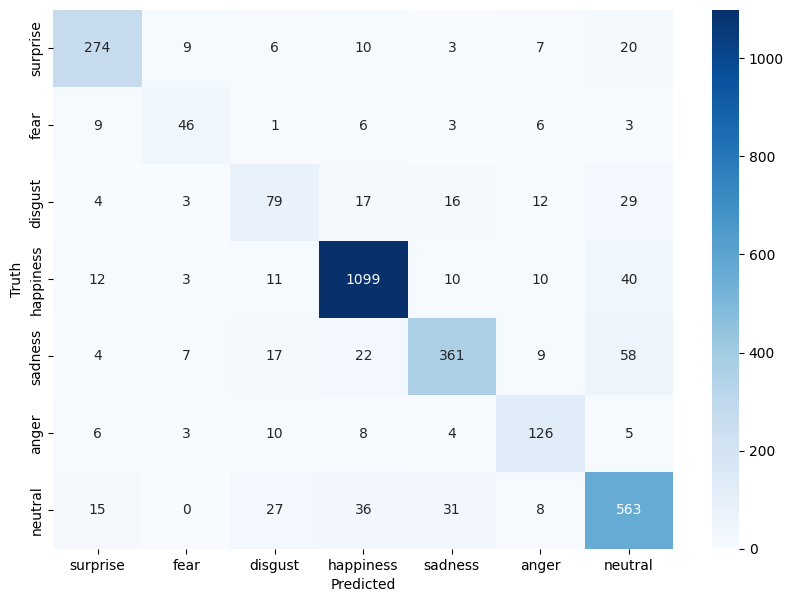

In [ ]:
efficientNet_checkpoint = torch.load(f'{folder_path}/MODELS/EfficientNet_B0_v2_best_model.pth')
best_efficientNet_model = EfficientNetB0(NUM_CLASSES)
best_efficientNet_model.load_state_dict(efficientNet_checkpoint)
evaluate_model_V2(best_efficientNet_model, test_loader, device)

100%|██████████| 96/96 [17:53<00:00, 11.18s/it]



Classification Report: 
               precision    recall  f1-score   support

    surprise     0.7966    0.8450    0.8201       329
        fear     0.5733    0.5811    0.5772        74
     disgust     0.6234    0.3000    0.4051       160
   happiness     0.9290    0.9055    0.9171      1185
     sadness     0.8554    0.7176    0.7804       478
       anger     0.6683    0.8333    0.7418       162
     neutral     0.7305    0.8691    0.7938       680

    accuracy                         0.8184      3068
   macro avg     0.7395    0.7217    0.7193      3068
weighted avg     0.8211    0.8184    0.8139      3068



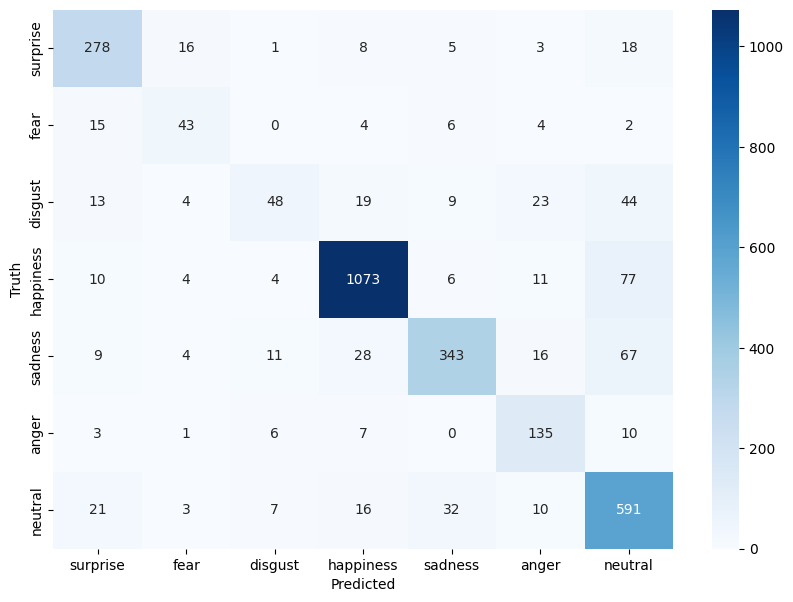

In [ ]:
viT_checkpoint = torch.load(f'{folder_path}/MODELS/ViT_v2_best_model.pth')
best_vit_model = ViT(NUM_CLASSES)
best_vit_model.load_state_dict(viT_checkpoint)
evaluate_model_V2(best_vit_model, test_loader, device)